In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import os
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [2]:
# Carga de datos y preparacion de datasets separados

DATA_DIR = Path('Data')
X_fourier_df = pd.read_csv(DATA_DIR / 'X' / 'X_fourier_processed.csv')
Y_df = pd.read_csv(DATA_DIR / 'Y' / 'Y.csv')

data_full = X_fourier_df.merge(
    Y_df[['filename', 'VehId', 'DayNum', 'Trip', 
          'Y_consumption_combustion_L_per_100km', 
          'Y_consumption_electric_kWh_per_km']], 
    on=['filename', 'VehId', 'DayNum', 'Trip'], 
    how='inner'
)

print(f"Dataset completo (Fourier): {len(data_full)} muestras")
print(f"\nDistribucion por tipo de vehiculo:")
if 'Vehicle Type' in data_full.columns:
    print(data_full['Vehicle Type'].value_counts().to_string())

# Dataset Combustion (ICE, HEV, PHEV)
data_combustion = data_full[data_full['Y_consumption_combustion_L_per_100km'].notna()].copy()
data_combustion = data_combustion[data_combustion['Y_consumption_combustion_L_per_100km'] > 0]

print(f"\nDATASET COMBUSTION:")
print(f"Muestras: {len(data_combustion)}")
if 'Vehicle Type' in data_combustion.columns:
    print(f"Por tipo: {data_combustion['Vehicle Type'].value_counts().to_dict()}")

# Dataset Electrico (PHEV, EV)
data_electric = data_full[data_full['Y_consumption_electric_kWh_per_km'].notna()].copy()
data_electric = data_electric[data_electric['Y_consumption_electric_kWh_per_km'] > 0]

print(f"\nDATASET ELECTRICO:")
print(f"Muestras: {len(data_electric)}")
if 'Vehicle Type' in data_electric.columns:
    print(f"Por tipo: {data_electric['Vehicle Type'].value_counts().to_dict()}")

Dataset completo (Fourier): 32512 muestras

Distribucion por tipo de vehiculo:
Vehicle Type
ICE     18903
HEV      9501
PHEV     3605
EV        503

DATASET COMBUSTION:
Muestras: 26633
Por tipo: {'ICE': 14684, 'HEV': 9324, 'PHEV': 2625}

DATASET ELECTRICO:
Muestras: 4124
Por tipo: {'PHEV': 3603, 'EV': 503, 'HEV': 18}


In [3]:
exclude_cols = [
    'filename', 'DayNum', 'Trip', 'Timestamp', 'Timestamp(ms)',
    'Y_consumption_combustion_L_per_100km', 
    'Y_consumption_electric_kWh_per_km'
]

# Identificar columnas de features (numericas)
feature_cols = [col for col in data_full.columns 
               if col not in exclude_cols 
               and col != 'VehId'
               and col != 'filename'
               and data_full[col].dtype in [np.float64, np.int64]]

print(f"Features (Fourier): {len(feature_cols)} columnas")

# Combustion
X_combustion = data_combustion[feature_cols].fillna(data_combustion[feature_cols].mean())
y_combustion = data_combustion['Y_consumption_combustion_L_per_100km'].values
veh_ids_combustion = data_combustion['VehId'].values if 'VehId' in data_combustion.columns else None

print(f"\nCOMBUSTION:")
print(f"X shape: {X_combustion.shape}")
print(f"y stats: mean={y_combustion.mean():.2f}, median={np.median(y_combustion):.2f}, std={y_combustion.std():.2f} L/100km")

# Electrico
X_electric = data_electric[feature_cols].fillna(data_electric[feature_cols].mean())
y_electric = data_electric['Y_consumption_electric_kWh_per_km'].values
veh_ids_electric = data_electric['VehId'].values if 'VehId' in data_electric.columns else None

print(f"\nELECTRICO:")
print(f"X shape: {X_electric.shape}")
print(f"y stats: mean={y_electric.mean():.4f}, median={np.median(y_electric):.4f}, std={y_electric.std():.4f} kWh/km")

Features (Fourier): 86 columnas

COMBUSTION:
X shape: (26633, 86)
y stats: mean=8.10, median=7.48, std=5.46 L/100km

ELECTRICO:
X shape: (4124, 86)
y stats: mean=0.1277, median=0.1339, std=0.0967 kWh/km


In [4]:
def create_splits(X, y, veh_ids=None, test_size=0.2, val_size=0.2, random_state=69):
    indices = np.arange(len(X))
    
    # dev (80%), test (20%)
    idx_dev, idx_test, X_dev, X_test, y_dev, y_test = train_test_split(
        indices, X, y, test_size=test_size, random_state=random_state
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, test_size=val_size, random_state=random_state
    )
    
    veh_ids_test = veh_ids[idx_test] if veh_ids is not None else None
    
    return X_train, X_val, X_test, y_train, y_val, y_test, veh_ids_test

# Combustion
X_train_comb, X_val_comb, X_test_comb, y_train_comb, y_val_comb, y_test_comb, veh_ids_test_comb = \
    create_splits(X_combustion, y_combustion, veh_ids_combustion)

print(f"COMBUSTION Splits:")
print(f"Train: {len(X_train_comb)} | Val: {len(X_val_comb)} | Test: {len(X_test_comb)}")

# Electrico
X_train_elec, X_val_elec, X_test_elec, y_train_elec, y_val_elec, y_test_elec, veh_ids_test_elec = \
    create_splits(X_electric, y_electric, veh_ids_electric)

print(f"\nELECTRICO Splits:")
print(f"Train: {len(X_train_elec)} | Val: {len(X_val_elec)} | Test: {len(X_test_elec)}")

COMBUSTION Splits:
Train: 17044 | Val: 4262 | Test: 5327

ELECTRICO Splits:
Train: 2639 | Val: 660 | Test: 825


In [5]:
# Escalado de features para ambos datasets

sanitized_feature_cols = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in feature_cols]

def scale_data(X_train, X_val, X_test, feature_cols, sanitized_cols):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=sanitized_cols, index=X_train.index)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=sanitized_cols, index=X_val.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=sanitized_cols, index=X_test.index)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Combustion
X_train_comb_scaled, X_val_comb_scaled, X_test_comb_scaled, scaler_comb = \
    scale_data(X_train_comb, X_val_comb, X_test_comb, feature_cols, sanitized_feature_cols)

print(f"COMBUSTION - Datos escalados:")
print(f"Train: {X_train_comb_scaled.shape} | Mean: {X_train_comb_scaled.mean().mean():.6f}")

# Electrico
X_train_elec_scaled, X_val_elec_scaled, X_test_elec_scaled, scaler_elec = \
    scale_data(X_train_elec, X_val_elec, X_test_elec, feature_cols, sanitized_feature_cols)

print(f"\nELECTRICO - Datos escalados:")
print(f"Train: {X_train_elec_scaled.shape} | Mean: {X_train_elec_scaled.mean().mean():.6f}")

COMBUSTION - Datos escalados:
Train: (17044, 86) | Mean: -0.000000

ELECTRICO - Datos escalados:
Train: (2639, 86) | Mean: 0.000000


In [6]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.abs(y_true))) * 100 if np.all(y_true != 0) else np.nan
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

def train_all_models(X_train, X_val, X_test, y_train, y_val, y_test, target_name):
    all_models = {}
    all_predictions = {}
    metrics_dict = {}
    
    print(f"ENTRENANDO MODELOS (FOURIER) - {target_name}")
    
    # LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    params = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 7, 'verbose': -1}
    model_lgbm = lgb.train(params, train_data, num_boost_round=300, valid_sets=[valid_data])
    preds_lgbm = model_lgbm.predict(X_test.values)
    all_models['LightGBM'] = model_lgbm
    all_predictions['LightGBM'] = preds_lgbm
    metrics_dict['LightGBM'] = calculate_metrics(y_test, preds_lgbm)
    
    # Random Forest
    model_rf = RandomForestRegressor(n_estimators=100, random_state=69, n_jobs=-1, max_depth=15)
    model_rf.fit(X_train, y_train)
    preds_rf = model_rf.predict(X_test)
    all_models['Random Forest'] = model_rf
    all_predictions['Random Forest'] = preds_rf
    metrics_dict['Random Forest'] = calculate_metrics(y_test, preds_rf)
    
    # XGBoost
    model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=69, n_jobs=-1)
    model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    preds_xgb = model_xgb.predict(X_test)
    all_models['XGBoost'] = model_xgb
    all_predictions['XGBoost'] = preds_xgb
    metrics_dict['XGBoost'] = calculate_metrics(y_test, preds_xgb)
    
    # Linear Models
    for name, model in [('Linear OLS', LinearRegression()), 
                        ('Linear Ridge', Ridge(alpha=1.0)), 
                        ('Linear Lasso', Lasso(alpha=0.001))]:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        all_models[name] = model
        all_predictions[name] = preds
        metrics_dict[name] = calculate_metrics(y_test, preds)
    
    for name, m in metrics_dict.items():
        print(f"   {name:20s} | RMSE: {m['RMSE']:.4f} | R2: {m['R2']:.4f}")
    
    return all_models, all_predictions, metrics_dict

# Entrenar Combustion
models_comb, preds_comb, metrics_comb = train_all_models(
    X_train_comb_scaled, X_val_comb_scaled, X_test_comb_scaled,
    y_train_comb, y_val_comb, y_test_comb, "COMBUSTION (L/100km)"
)

# Entrenar Electrico
models_elec, preds_elec, metrics_elec = train_all_models(
    X_train_elec_scaled, X_val_elec_scaled, X_test_elec_scaled,
    y_train_elec, y_val_elec, y_test_elec, "ELECTRICO (kWh/km)"
)

ENTRENANDO MODELOS (FOURIER) - COMBUSTION (L/100km)


   LightGBM             | RMSE: 3.2331 | R2: 0.5846
   Random Forest        | RMSE: 3.7347 | R2: 0.4457
   XGBoost              | RMSE: 2.9639 | R2: 0.6509
   Linear OLS           | RMSE: 4.3498 | R2: 0.2481
   Linear Ridge         | RMSE: 4.3493 | R2: 0.2483
   Linear Lasso         | RMSE: 4.3482 | R2: 0.2487
ENTRENANDO MODELOS (FOURIER) - ELECTRICO (kWh/km)
   LightGBM             | RMSE: 0.0860 | R2: 0.4202
   Random Forest        | RMSE: 0.0858 | R2: 0.4222
   XGBoost              | RMSE: 0.0853 | R2: 0.4290
   Linear OLS           | RMSE: 0.0954 | R2: 0.2863
   Linear Ridge         | RMSE: 0.0953 | R2: 0.2870
   Linear Lasso         | RMSE: 0.0948 | R2: 0.2943


In [7]:
# Comparacion de metricas - Combustion vs Electrico

df_comb = pd.DataFrame(metrics_comb).T
df_comb['Target'] = 'Combustion'

df_elec = pd.DataFrame(metrics_elec).T
df_elec['Target'] = 'Electrico'

print("RESULTADOS COMBUSTION (L/100km) - FOURIER:")
print(df_comb[['RMSE', 'MAE', 'R2', 'MAPE']].round(4).to_string())

print("\nRESULTADOS ELECTRICO (kWh/km) - FOURIER:")
print(df_elec[['RMSE', 'MAE', 'R2', 'MAPE']].round(4).to_string())

# Mejor modelo por target
best_comb = df_comb['R2'].idxmax()
best_elec = df_elec['R2'].idxmax()

print(f"\nMEJORES MODELOS (FOURIER):")
print(f"Combustion: {best_comb} (R2 = {df_comb.loc[best_comb, 'R2']:.4f})")
print(f"Electrico:  {best_elec} (R2 = {df_elec.loc[best_elec, 'R2']:.4f})")

RESULTADOS COMBUSTION (L/100km) - FOURIER:
                 RMSE     MAE      R2     MAPE
LightGBM       3.2331  1.6938  0.5846  23.7324
Random Forest  3.7347  1.7905  0.4457  24.4289
XGBoost        2.9639  1.5876  0.6509  21.9489
Linear OLS     4.3498  2.4310  0.2481  37.8534
Linear Ridge   4.3493  2.4300  0.2483  37.8407
Linear Lasso   4.3482  2.4275  0.2487  37.8198

RESULTADOS ELECTRICO (kWh/km) - FOURIER:
                 RMSE     MAE      R2      MAPE
LightGBM       0.0860  0.0413  0.4202  199.3202
Random Forest  0.0858  0.0412  0.4222  218.8172
XGBoost        0.0853  0.0401  0.4290  193.3487
Linear OLS     0.0954  0.0523  0.2863  344.0691
Linear Ridge   0.0953  0.0522  0.2870  344.7535
Linear Lasso   0.0948  0.0526  0.2943  363.4944

MEJORES MODELOS (FOURIER):
Combustion: XGBoost (R2 = 0.6509)
Electrico:  XGBoost (R2 = 0.4290)


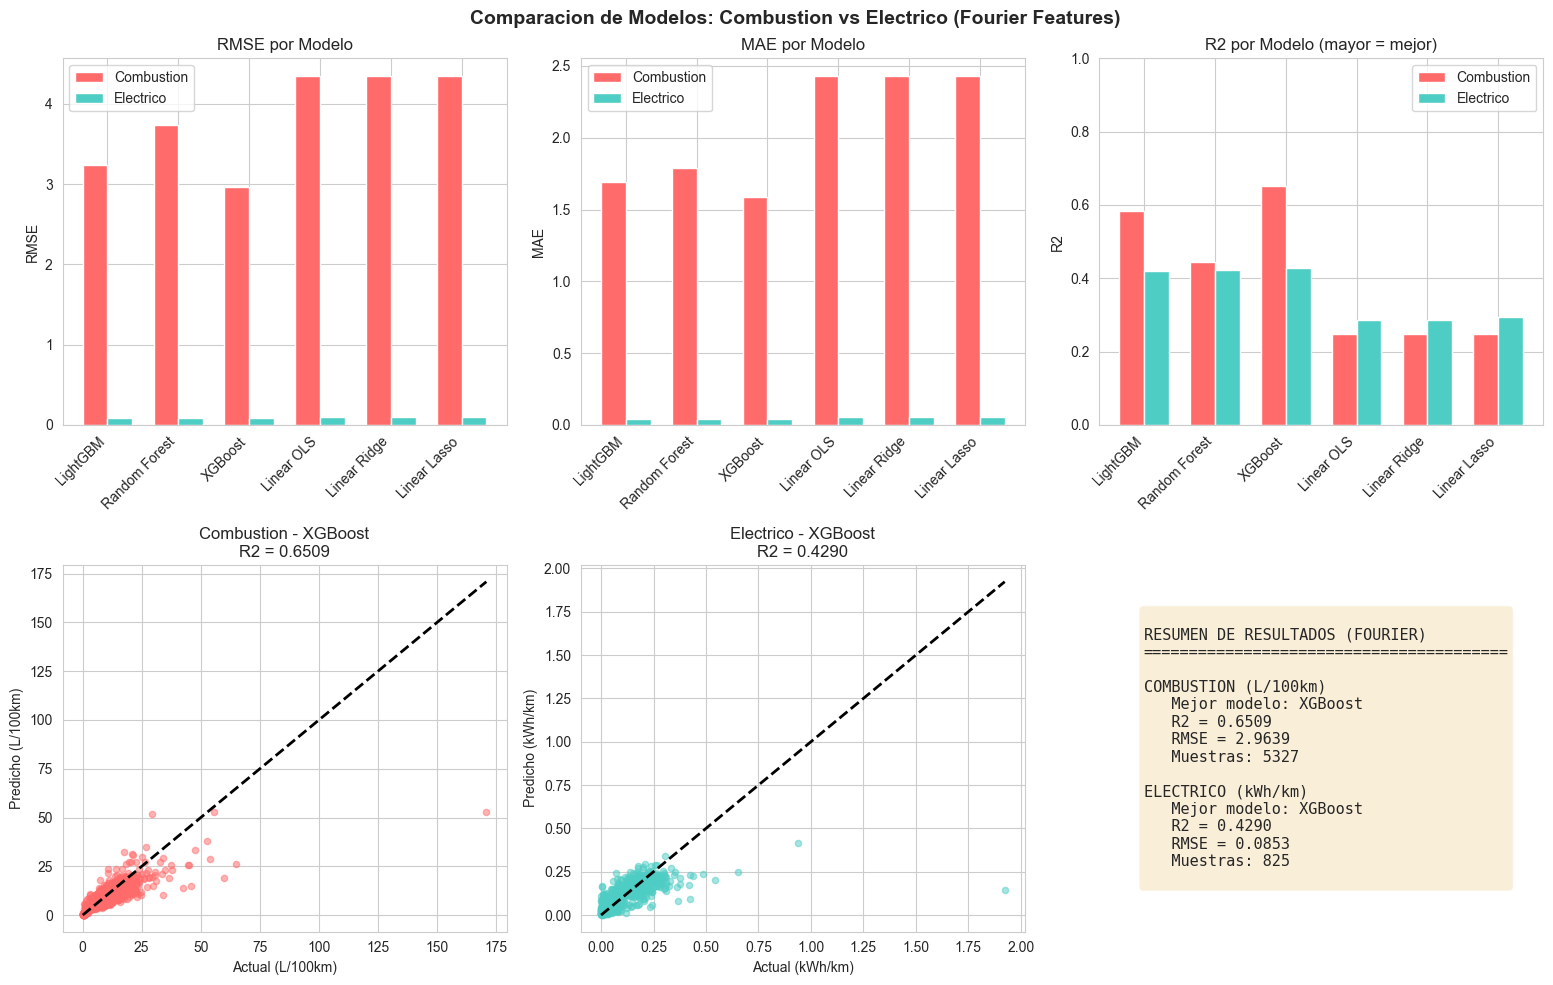

In [8]:
# Grafico comparativo: Combustion vs Electrico (Fourier)

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

model_names = list(metrics_comb.keys())

# Fila 1: Metricas
# RMSE
ax = axes[0, 0]
x = np.arange(len(model_names))
width = 0.35
bars1 = ax.bar(x - width/2, [metrics_comb[m]['RMSE'] for m in model_names], width, label='Combustion', color='#FF6B6B')
bars2 = ax.bar(x + width/2, [metrics_elec[m]['RMSE'] for m in model_names], width, label='Electrico', color='#4ECDC4')
ax.set_ylabel('RMSE')
ax.set_title('RMSE por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

# MAE
ax = axes[0, 1]
bars1 = ax.bar(x - width/2, [metrics_comb[m]['MAE'] for m in model_names], width, label='Combustion', color='#FF6B6B')
bars2 = ax.bar(x + width/2, [metrics_elec[m]['MAE'] for m in model_names], width, label='Electrico', color='#4ECDC4')
ax.set_ylabel('MAE')
ax.set_title('MAE por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

# R2
ax = axes[0, 2]
bars1 = ax.bar(x - width/2, [metrics_comb[m]['R2'] for m in model_names], width, label='Combustion', color='#FF6B6B')
bars2 = ax.bar(x + width/2, [metrics_elec[m]['R2'] for m in model_names], width, label='Electrico', color='#4ECDC4')
ax.set_ylabel('R2')
ax.set_title('R2 por Modelo (mayor = mejor)')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

# Fila 2: Scatter plots del mejor modelo
# Combustion
ax = axes[1, 0]
best_preds_comb = preds_comb[best_comb]
ax.scatter(y_test_comb, best_preds_comb, alpha=0.5, s=20, c='#FF6B6B')
min_val, max_val = min(y_test_comb.min(), best_preds_comb.min()), max(y_test_comb.max(), best_preds_comb.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
ax.set_xlabel('Actual (L/100km)')
ax.set_ylabel('Predicho (L/100km)')
ax.set_title(f'Combustion - {best_comb}\nR2 = {metrics_comb[best_comb]["R2"]:.4f}')

# Electrico
ax = axes[1, 1]
best_preds_elec = preds_elec[best_elec]
ax.scatter(y_test_elec, best_preds_elec, alpha=0.5, s=20, c='#4ECDC4')
min_val, max_val = min(y_test_elec.min(), best_preds_elec.min()), max(y_test_elec.max(), best_preds_elec.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
ax.set_xlabel('Actual (kWh/km)')
ax.set_ylabel('Predicho (kWh/km)')
ax.set_title(f'Electrico - {best_elec}\nR2 = {metrics_elec[best_elec]["R2"]:.4f}')

# Resumen de resultados
ax = axes[1, 2]
ax.axis('off')
summary_text = f"""
RESUMEN DE RESULTADOS (FOURIER)
{'='*40}

COMBUSTION (L/100km)
   Mejor modelo: {best_comb}
   R2 = {metrics_comb[best_comb]['R2']:.4f}
   RMSE = {metrics_comb[best_comb]['RMSE']:.4f}
   Muestras: {len(y_test_comb)}

ELECTRICO (kWh/km)
   Mejor modelo: {best_elec}
   R2 = {metrics_elec[best_elec]['R2']:.4f}
   RMSE = {metrics_elec[best_elec]['RMSE']:.4f}
   Muestras: {len(y_test_elec)}
"""
ax.text(0.1, 0.5, summary_text, fontsize=11, family='monospace', 
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Comparacion de Modelos: Combustion vs Electrico (Fourier Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/fourier_combustion_vs_electric.png', dpi=150, bbox_inches='tight')
plt.show()

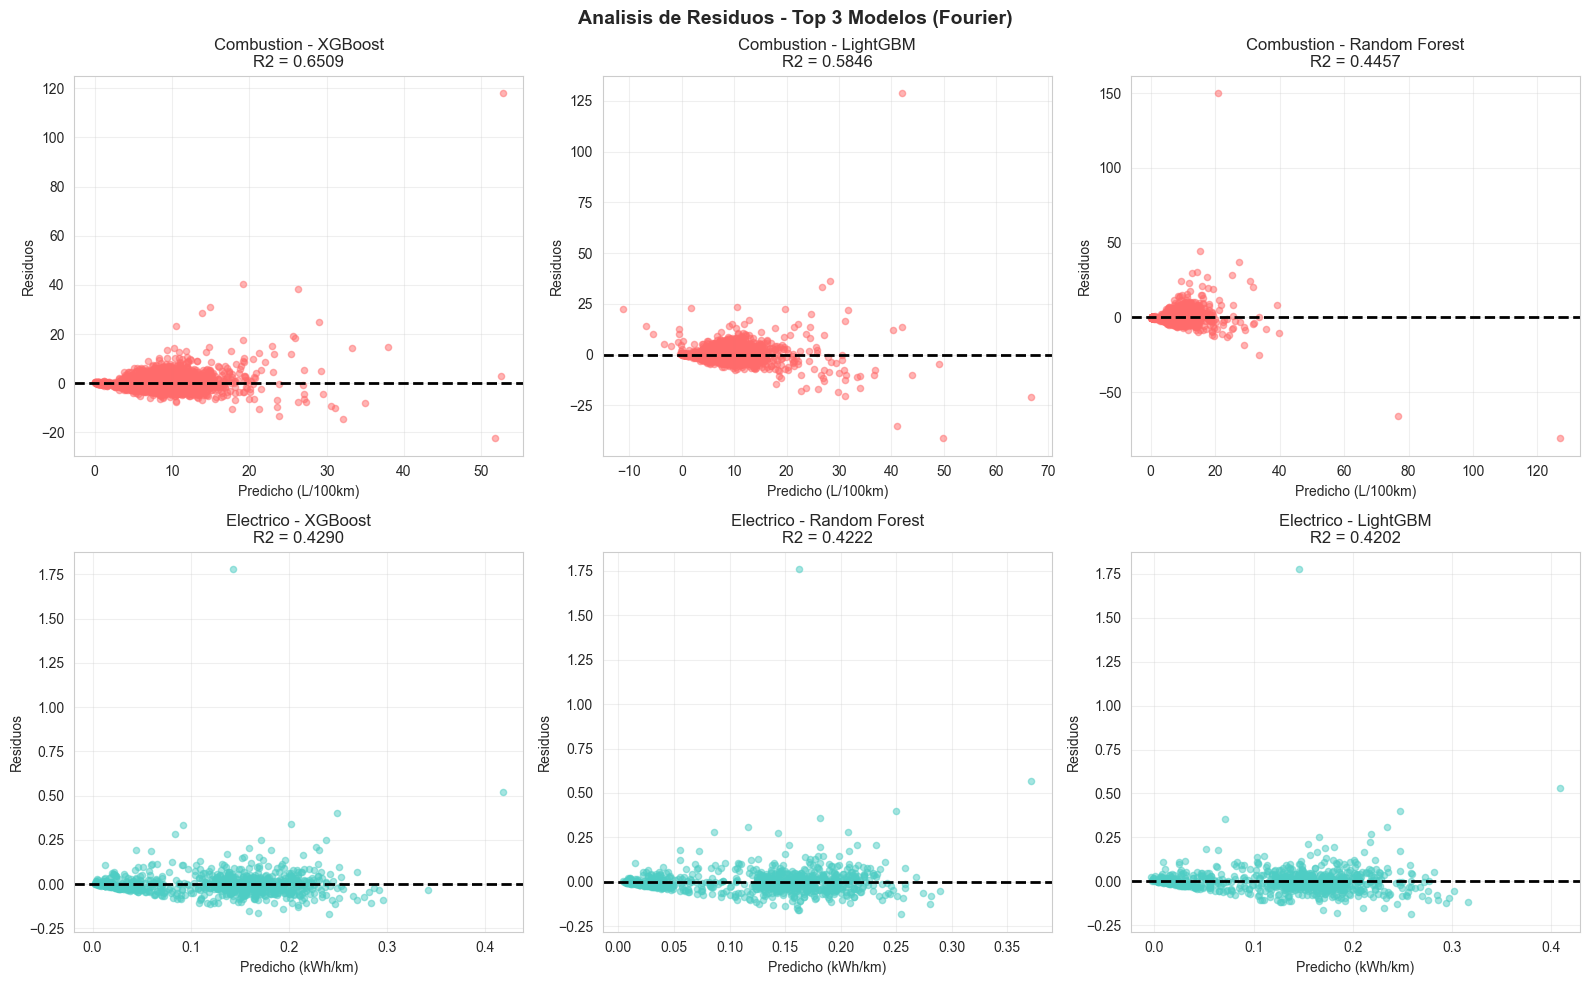

In [9]:
# Graficos de Residuos - Top 3 Modelos por Target

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

top3_comb = sorted(metrics_comb.keys(), key=lambda x: metrics_comb[x]['R2'], reverse=True)[:3]
top3_elec = sorted(metrics_elec.keys(), key=lambda x: metrics_elec[x]['R2'], reverse=True)[:3]

# Fila 1: Combustion
for idx, model_name in enumerate(top3_comb):
    ax = axes[0, idx]
    preds = preds_comb[model_name]
    residuals = y_test_comb - preds
    
    ax.scatter(preds, residuals, alpha=0.5, s=20, c='#FF6B6B')
    ax.axhline(y=0, color='k', linestyle='--', lw=2)
    ax.set_xlabel('Predicho (L/100km)')
    ax.set_ylabel('Residuos')
    ax.set_title(f'Combustion - {model_name}\nR2 = {metrics_comb[model_name]["R2"]:.4f}')
    ax.grid(True, alpha=0.3)

# Fila 2: Electrico
for idx, model_name in enumerate(top3_elec):
    ax = axes[1, idx]
    preds = preds_elec[model_name]
    residuals = y_test_elec - preds
    
    ax.scatter(preds, residuals, alpha=0.5, s=20, c='#4ECDC4')
    ax.axhline(y=0, color='k', linestyle='--', lw=2)
    ax.set_xlabel('Predicho (kWh/km)')
    ax.set_ylabel('Residuos')
    ax.set_title(f'Electrico - {model_name}\nR2 = {metrics_elec[model_name]["R2"]:.4f}')
    ax.grid(True, alpha=0.3)

plt.suptitle('Analisis de Residuos - Top 3 Modelos (Fourier)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/fourier_residuals_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

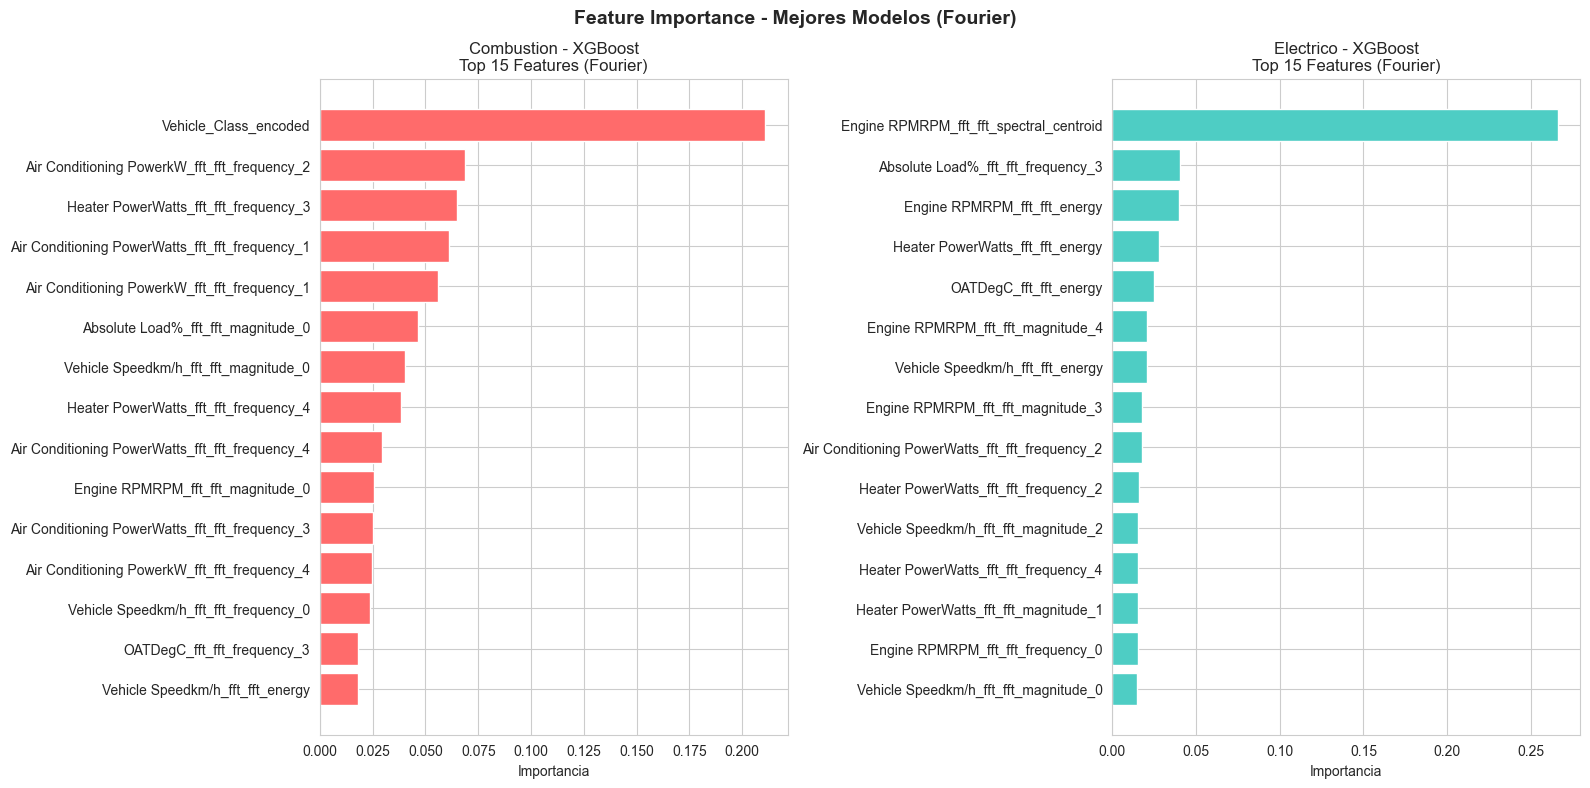

In [10]:
# Feature Importance - Mejor Modelo por Target

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

def get_feature_importance(model, feature_names, n_top=15):
    if hasattr(model, 'feature_importance'):
        importance = model.feature_importance(importance_type='gain')
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        return None, None
    
    indices = np.argsort(importance)[::-1][:n_top]
    return np.array(feature_names)[indices], importance[indices]

# Combustion
ax = axes[0]
feat_names, feat_imp = get_feature_importance(models_comb[best_comb], sanitized_feature_cols)
if feat_names is not None:
    ax.barh(feat_names[::-1], feat_imp[::-1], color='#FF6B6B')
    ax.set_xlabel('Importancia')
    ax.set_title(f'Combustion - {best_comb}\nTop 15 Features (Fourier)')

# Electrico
ax = axes[1]
feat_names, feat_imp = get_feature_importance(models_elec[best_elec], sanitized_feature_cols)
if feat_names is not None:
    ax.barh(feat_names[::-1], feat_imp[::-1], color='#4ECDC4')
    ax.set_xlabel('Importancia')
    ax.set_title(f'Electrico - {best_elec}\nTop 15 Features (Fourier)')

plt.suptitle('Feature Importance - Mejores Modelos (Fourier)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/fourier_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
#Save models, scalers, and feature names

os.makedirs('models/saved_models', exist_ok=True)

for name, model in models_comb.items():
    safe_name = name.replace(' ', '_')
    joblib.dump(model, f'models/saved_models/fourier_combustion_{safe_name}.pkl')

for name, model in models_elec.items():
    safe_name = name.replace(' ', '_')
    joblib.dump(model, f'models/saved_models/fourier_electric_{safe_name}.pkl')

joblib.dump(scaler_comb, 'models/saved_models/fourier_scaler_combustion.pkl')
joblib.dump(scaler_elec, 'models/saved_models/fourier_scaler_electric.pkl')

joblib.dump(sanitized_feature_cols, 'models/saved_models/fourier_feature_names.pkl')

print("Modelos guardados en models/saved_models/")

print("RESUMEN FINAL - MODELOS FOURIER")

print("\nCOMBUSTION (L/100km):")
df_comb = pd.DataFrame(metrics_comb).T.sort_values('RMSE')
print(df_comb.to_string())

print("\nELECTRICO (kWh/km):")
df_elec = pd.DataFrame(metrics_elec).T.sort_values('RMSE')
print(df_elec.to_string())

Modelos guardados en models/saved_models/
RESUMEN FINAL - MODELOS FOURIER

COMBUSTION (L/100km):
                     MSE      RMSE       MAE        R2       MAPE
XGBoost         8.784885  2.963931  1.587614  0.650908  21.948914
LightGBM       10.452613  3.233050  1.693819  0.584636  23.732358
Random Forest  13.947789  3.734674  1.790503  0.445746  24.428907
Linear Lasso   18.906479  4.348158  2.427477  0.248699  37.819808
Linear Ridge   18.916725  4.349336  2.430018  0.248291  37.840665
Linear OLS     18.921103  4.349839  2.430962  0.248117  37.853383

ELECTRICO (kWh/km):
                    MSE      RMSE       MAE        R2        MAPE
XGBoost        0.007279  0.085316  0.040098  0.429043  193.348703
Random Forest  0.007367  0.085829  0.041168  0.422165  218.817180
LightGBM       0.007391  0.085971  0.041255  0.420250  199.320161
Linear Lasso   0.008996  0.094849  0.052588  0.294331  363.494364
Linear Ridge   0.009089  0.095338  0.052235  0.287035  344.753543
Linear OLS     0.009099 